# Word2Vec

Word embeddings presented by Tomas Mikolov et al. in 2013 in 2 papers: "Efficient Estimation of Word Representations in Vector Space" and 

They presented 2 models that are called CBOW and Skip-gram. 

In the ***CBOW*** model, the distributed representations of context are used to predict the word in the middle of the window.

$J_\theta = \frac{1}{T}\sum^{T}_{t=1}\log{p}\left(w_{t}\mid{w}_{t-n},\ldots,w_{t-1}, w_{t+1},\ldots,w_{t+n}\right)$

each word ${w}_{i}$ is represented by a vector ${x}_{i}$ of dimension $V$

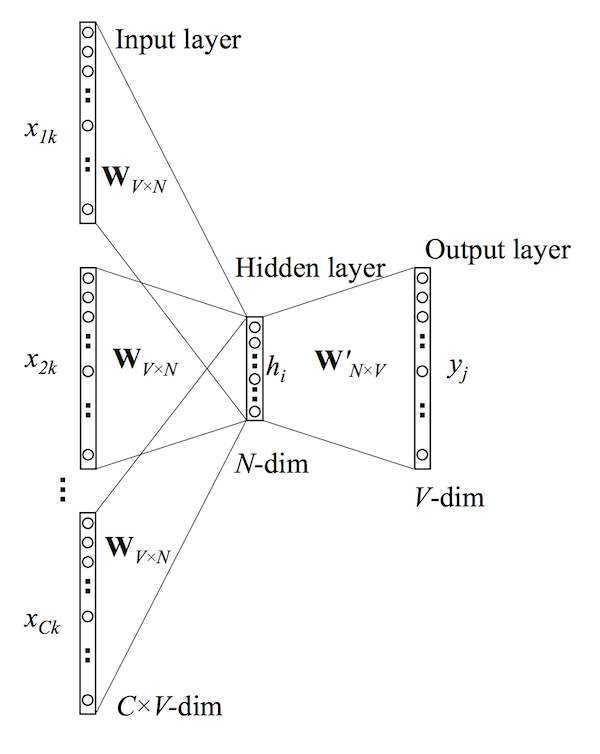

**Skip-gram** 

Skip-gram Word2Vec is an architecture for computing word embeddings. Instead of using surrounding words to predict the center word, as with CBow Word2Vec, Skip-gram Word2Vec uses the central word to predict the surrounding words.

The skip-gram objective function sums the log probabilities of the surrounding n
words to the left and right of the target word $w_{t}$ to produce the following objective:
$J_\theta = \frac{1}{T}\sum^{T}_{t=1}\sum_{-n\leq{j}\leq{n}, \neq{0}}\log{p}\left(w_{j+1}\mid{w_{t}}\right)$

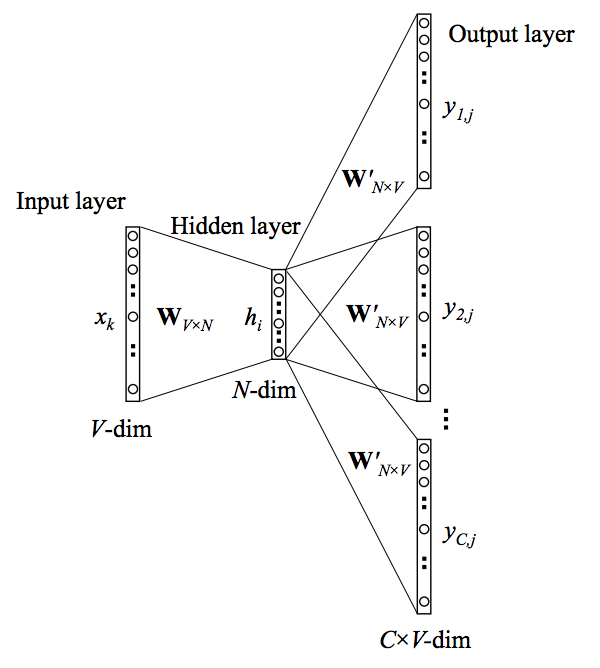

# Scratch implementation 

In [11]:
for context, target in ngrams:
    context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
    break

In [12]:
context_idxs

tensor([ 52, 111, 113])

In [16]:
from word2vec_utils import word2vec_utils as wv

config = yaml.safe_load(open(f'../config/config_word2vec.yml'))
config_name = 'word2vec_ita_custom'

CONTEXT_SIZE = config[config_name]["CONTEXT_SIZE"]
EMBEDDING_DIM = config[config_name]["EMBEDDING_DIM"]
SEED = config[config_name]["SEED"]
LEARNING_RATE = config[config_name]["LEARNING_RATE"]

name_model = f'{config_name}'
path_saving_model = f'../results/embeddings/{name_model}_embeddings.npy'

torch.manual_seed(SEED)

test_sentence = """Empathy for the poor may not come easily to people who never experienced it. They may blame the victims and insist their predicament can be overcome through determination and hard work.
But they may not realize that extreme poverty can be psychologically and physically incapacitating — a perpetual cycle of bad diets, health care and education exacerbated by the shaming and self-fulfilling prophecies that define it in the public imagination.
Gordon Parks — perhaps more than any artist — saw poverty as “the most savage of all human afflictions” and realized the power of empathy to help us understand it. It was neither an abstract problem nor political symbol, but something he endured growing up destitute in rural Kansas and having spent years documenting poverty throughout the world, including the United States.
That sensitivity informed “Freedom’s Fearful Foe: Poverty,” his celebrated photo essay published in Life magazine in June 1961. He took readers into the lives of a Brazilian boy, Flavio da Silva, and his family, who lived in the ramshackle Catacumba favela in the hills outside Rio de Janeiro. These stark photographs are the subject of a new book, “Gordon Parks: The Flavio Story” (Steidl/The Gordon Parks Foundation), which accompanies a traveling exhibition co-organized by the Ryerson Image Centre in Toronto, where it opens this week, and the J. Paul Getty Museum. Edited with texts by the exhibition’s co-curators, Paul Roth and Amanda Maddox, the book also includes a recent interview with Mr. da Silva and essays by Beatriz Jaguaribe, Maria Alice Rezende de Carvalho and Sérgio Burgi.
""".split()
# we should tokenize the input, but we will ignore that for now
# build a list of tuples.  Each tuple is ([ word_i-2, word_i-1 ], target word)

ngrams = []
for i in range(len(test_sentence) - CONTEXT_SIZE):
    tup = [test_sentence[j] for j in np.arange(i , i + CONTEXT_SIZE) ]
    ngrams.append((tup,test_sentence[i + CONTEXT_SIZE]))

vocab = set(test_sentence)
print("Length of vocabulary",len(vocab))
word_to_ix = {word: i for i, word in enumerate(vocab)}

losses = []
loss_function = nn.NLLLoss()
model = wv.CBOWModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr = LEARNING_RATE )

# Freeze embedding layer
#model.freeze_layer('embeddings')

for epoch in range(1):
    total_loss = 0
    #------- Embedding layers are trained as well here ----#
    #lookup_tensor = torch.tensor([word_to_ix["poor"]], dtype=torch.long)
    #hello_embed = model.embeddings(lookup_tensor)
    #print(hello_embed)
    # -----------------------------------------------------#

    for context, target in ngrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
        #print("Context id",context_idxs)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)
               #print(log_probs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))
        #print(loss)

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    print(total_loss)
    losses.append(total_loss)
#print(losses)  # The loss decreased every iteration over the training data!

#Print the model layer parameters
#model.print_layer_parameters()

#Predict the next word given n context words
model.predict(['of','all','human'])
we = model.write_embedding_to_file('embeddings.npy')
wv.cluster_embeddings('embeddings.npy',2)

Length of vocabulary 195
1364.271638393402
[('boy,', 43, tensor(-4.5558, grad_fn=<UnbindBackward>))]
[('new', 77, tensor(-4.5617, grad_fn=<UnbindBackward>))]
[('co-organized', 140, tensor(-4.5734, grad_fn=<UnbindBackward>))]
129
through
193
book
